In [1]:
import gooseberry as gs

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Ellipse
import numpy as np

import jax
import jax.numpy as jnp
from functools import partial
import torch

# from dynamics import QQT
from tools import BlindColours, zero_balanced_weights

# import gooseberry as gs
from lambda_balanced import QQT_lambda_balanced3
from linear_network import LinearNetwork 
from utils import get_random_regression_task, get_lambda_balanced, balanced_weights

# from empiricalTest import LinearNetwork, get_random_regression_task


(array([[-0.50340918, -0.97086302, -0.46328743],
       [ 0.92327362, -0.3806556 ,  0.57745666],
       [-0.08909043, -0.64506705,  0.55803507]]), array([[ 4.16259554e-01,  7.03170134e-01, -2.79563141e-04],
       [ 1.13611936e+00, -7.27040508e-01,  1.54074507e-01],
       [ 2.60405551e-01,  6.54959639e-01,  9.12651040e-01]]), array([[1.79586278, 0.        , 0.        ],
       [0.        , 1.58066839, 0.        ],
       [0.        , 0.        , 0.27334651]]), array([[-1.21219209e-01,  2.22044605e-16,  0.00000000e+00],
       [ 2.22044605e-16, -1.21219209e-01, -5.55111512e-17],
       [ 0.00000000e+00, -5.55111512e-17, -1.21219209e-01]]))


In [2]:
bc = BlindColours(False)
blind_colours = bc.get_colours()
div_cmap = bc.get_div_cmap()
colour_steps = bc.get_colour_steps()

In [168]:
np.random.seed(2)

in_dim = 5
hidden_dim = 5
out_dim = 5

batch_size = 25 
learning_rate = 0.01
training_steps = 6000

lmda = 1

num_datas = 4

training_datas = []
for i in range(num_datas):
    X, Y = get_random_regression_task(batch_size, in_dim, out_dim)
    training_datas.append((X, Y))

losses = [[] for _ in range(4)]

ws = []
analyticals = None

curr_w1 = None
curr_w2 = None

for i, (X, Y) in enumerate(training_datas):
    if i == 0:
        init_w1, init_w2 = get_lambda_balanced(lmda, in_dim, hidden_dim, out_dim)
        # init_w1 = torch.tensor(init_w1)
        # init_w2 = torch.tensor(init_w2)
    else:
        init_w1, init_w2, = curr_w1, curr_w2
        # init_w1, init_w2 = torch.tensor(curr_w1), torch.tensor(curr_w2) 


    model = LinearNetwork(in_dim, hidden_dim, out_dim, init_w1.copy(), init_w2.copy())

    # print('X: ', X.shape)
    # print('Y: ', Y.shape)
    # print('init_w1: ', init_w1.shape)
    # print('init_w2: ', init_w2.shape)
    w1s, w2s, _ = model.train(X, Y, training_steps, learning_rate) 

    analytical = QQT_lambda_balanced3(init_w1.copy(), init_w2.copy(), X.T, Y.T, True)
    analytical = np.asarray([analytical.forward(learning_rate) for _ in range(training_steps)])
    print('working')

    ws_analytical = np.array([a[in_dim:, :out_dim] for a in analytical])

    # ws = np.concatenate(ws, np.asarray([w2 @ w1 for (w2, w1) in zip(w2s, w1s)]))
    ws = ws + [w2 @ w1 for (w2, w1) in zip(w2s, w1s)]
    # analyticals = np.concatenate(analyticals, np.asarray(analytical))
    if analyticals is None :
        analyticals = analytical 
    else:
        analyticals = np.concatenate((analyticals, analytical))
    # analyticals.append(analytical)
        
        

    curr_w1, curr_w2 = w1s[-1], w2s[-1]

for j, (X, Y) in enumerate(training_datas):
    loss_empirical = [1/(2*batch_size) * np.linalg.norm(w @ X - Y)**2 for w in ws]
    # loss_empirical = ...
    losses[j] = loss_empirical
ws = np.asarray(ws)
analyticals = np.asarray(analyticals)


working
working
working
working


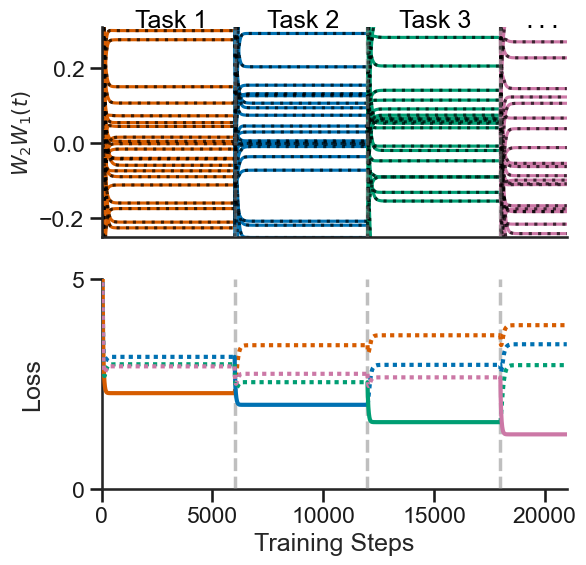

In [170]:
last_task_lim = training_steps // 2
fig, axs = plt.subplots(2, 1, figsize=(6, 6))

for i, (colour, rng) in enumerate(zip(blind_colours, [training_steps * j for j in range(1, 4)] + [training_steps * 4 - 1])):
    start = rng - training_steps
    end = rng
    axs[0].plot(range(start, end), ws[start:end].reshape(-1, in_dim * out_dim), c=colour)
    for j in range(2):
        axs[j].axvline(end, linestyle="--", c="grey", alpha=0.5, lw=2.5, zorder=3)
        
    for j, (colour, loss) in enumerate(zip(blind_colours, losses)):
        if i != j:
            axs[1].plot(range(start, end), loss[start:end], c=colour, lw=3., linestyle=(0, (1, 1)), zorder=4)
        else:
            axs[1].plot(range(start, end), loss[start:end], c=colour, lw=3., zorder=4)
axs[0].plot(analyticals.reshape(-1, in_dim * out_dim)[:-last_task_lim], c="k", alpha=0.7, linestyle=(0, (1, 2)))

for i in range(2):
    axs[i].set_xlim(0., end-last_task_lim)

axs[0].set_ylim(-.25, .31)
axs[0].set_yticks([-.2, 0., .2])
axs[0].set_xticks([])

axs[1].set_ylim(0.3, .68)
axs[1].set_yticks([0., 5.])
axs[1].set_xticks(range(0, 20001, 5000))

for i, x_pos in enumerate([0.18, 0.40, 0.62]):
    fig.text(x_pos, 0.88, f"Task {i+1}", fontsize=18, c="k")
fig.text(0.83, 0.88, "$...$", fontsize=18, c="k")

axs[0].set_ylabel("$W_2W_1(t)$", fontsize=15)
axs[1].set_ylabel("Loss", labelpad=20.)
axs[1].set_xlabel("Training Steps")

sns.despine()
fig.savefig("./figures/figure-5_a.svg")